In [1]:

from pathlib import Path

# Step 1: Define the base path
base_path = Path(r"C:\Dataset\LFP-50%SOH\Data")  # Use raw string to handle backslashes

# Step 2: Recursively find all folders and subfolders
folder_list = sorted({p.parent for p in base_path.rglob('*') if p.is_file()})
print(f"Found {len(folder_list)} folders (including subfolders):\n")

# Step 3: Print each folder path
for folder in folder_list:
    print(folder)

# Optional: Save the list to a text file
# with open("folder_list.txt", "w") as f:
#     for folder in folder_list:
#         f.write(str(folder) + "\n")


Found 100 folders (including subfolders):

C:\Dataset\LFP-50%SOH\Data\Cell1a\Cell1a\agingdata_50degC
C:\Dataset\LFP-50%SOH\Data\Cell1a\Cell1a\finalcharac_25degC
C:\Dataset\LFP-50%SOH\Data\Cell1a\Cell1a\finalcharac_25degC\EIS
C:\Dataset\LFP-50%SOH\Data\Cell1a\Cell1a\initialcharac_25degC
C:\Dataset\LFP-50%SOH\Data\Cell1a\Cell1a\initialcharac_25degC\EIS
C:\Dataset\LFP-50%SOH\Data\Cell1b\Cell1b\agingdata_50degC
C:\Dataset\LFP-50%SOH\Data\Cell1b\Cell1b\finalcharac_25degC
C:\Dataset\LFP-50%SOH\Data\Cell1b\Cell1b\finalcharac_25degC\EIS
C:\Dataset\LFP-50%SOH\Data\Cell1b\Cell1b\initialcharac_25degC
C:\Dataset\LFP-50%SOH\Data\Cell1b\Cell1b\initialcharac_25degC\EIS
C:\Dataset\LFP-50%SOH\Data\Cell1c\Cell1c\agingdata_50degC
C:\Dataset\LFP-50%SOH\Data\Cell1c\Cell1c\finalcharac_25degC
C:\Dataset\LFP-50%SOH\Data\Cell1c\Cell1c\finalcharac_25degC\EIS
C:\Dataset\LFP-50%SOH\Data\Cell1c\Cell1c\initialcharac_25degC
C:\Dataset\LFP-50%SOH\Data\Cell1c\Cell1c\initialcharac_25degC\EIS
C:\Dataset\LFP-50%SOH\Data\

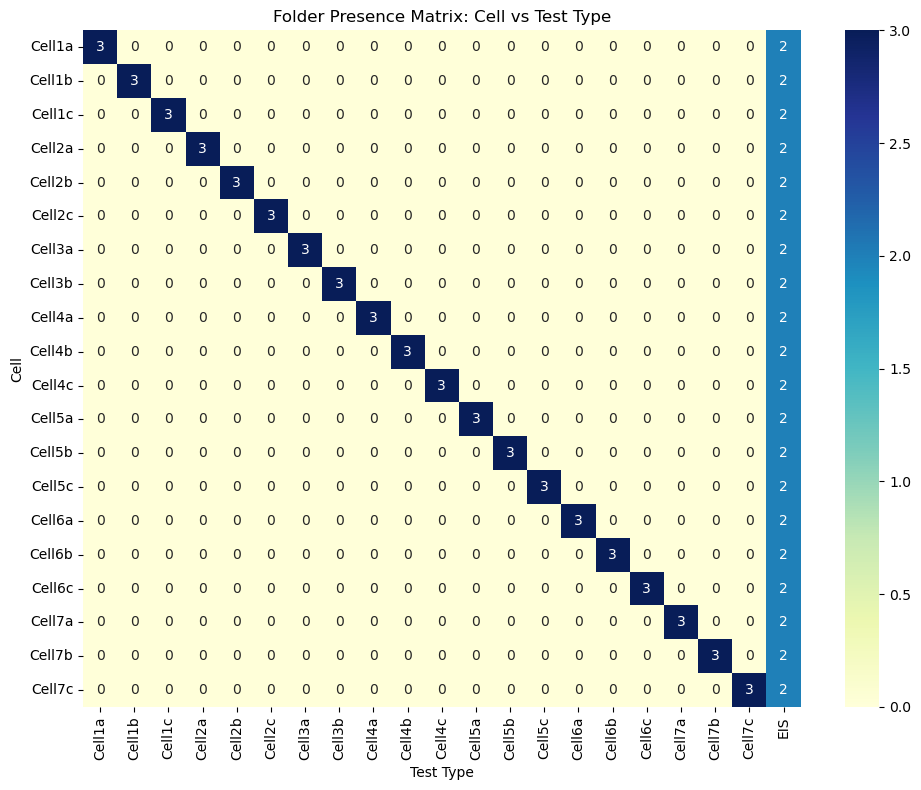

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set base path
base_path = Path(r"C:\Dataset\LFP-50%SOH\Data")

# Step 2: Get all folders with files
folder_paths = sorted({p.parent for p in base_path.rglob('*') if p.is_file()})

# Step 3: Parse folder info
records = []
for path in folder_paths:
    parts = path.parts
    try:
        cell = parts[-3]  # e.g., Cell1a
        test_type = parts[-1] if parts[-2] != parts[-3] else parts[-2]
        eis = 'EIS' if 'EIS' in parts else 'No EIS'
        records.append({'Cell': cell, 'TestType': test_type.replace('_', ' '), 'EIS': eis})
    except IndexError:
        continue

df = pd.DataFrame(records)


# Step 5: Plot 2 – Heatmap of Cells vs Test Types
pivot = df.pivot_table(index='Cell', columns='TestType', values='EIS', aggfunc='count', fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Folder Presence Matrix: Cell vs Test Type')
plt.xlabel('Test Type')
plt.ylabel('Cell')
plt.tight_layout()
plt.show()



In [3]:
from pathlib import Path

# Step 1: Define base path
base_path = Path(r"C:\Dataset\LFP-50%SOH\Data")

# Step 2: Get list of all file paths recursively
file_list = sorted([str(p) for p in base_path.rglob('*') if p.is_file()])

# Step 3: Save to a text file
output_file = "file_list.txt"
with open(output_file, "w", encoding="utf-8") as f:
    for file in file_list:
        f.write(file + "\n")

print(f"Saved {len(file_list)} file paths to {output_file}")


Saved 1834 file paths to file_list.txt


In [4]:
import os
from pathlib import Path
import shutil
import re

# Paths
input_root = Path(r"C:\Dataset\LFP-50%SOH\Data")
output_root = Path(r"C:\Dataset\Segmented")
output_root.mkdir(exist_ok=True)

# Relaxed pattern matching (look for keyword anywhere in filename)
patterns = {
    'Initial_EIS': re.compile(r'initial_soc\d{3}pct', re.IGNORECASE),
    'Final_EIS': re.compile(r'final_soc\d{3}pct', re.IGNORECASE),
    'Aging_Data': re.compile(r'aging\d{4}to\d{4}', re.IGNORECASE),
    'Characterization': re.compile(r'charac\d{3,4}', re.IGNORECASE),
    'Summaries': re.compile(r'(initialcharac|finalcharac)', re.IGNORECASE)
}

# Classification
unclassified = []

for file in input_root.rglob("*.csv"):
    matched = False
    for label, pattern in patterns.items():
        if pattern.search(file.name):  # ← use .search() instead of .fullmatch()
            dest_folder = output_root / label
            dest_folder.mkdir(parents=True, exist_ok=True)
            shutil.copy(file, dest_folder / file.name)
            matched = True
            break
    if not matched:
        unclassified.append(file)

# Report
print("✅ Segmentation complete.")
for label in patterns.keys():
    count = len(list((output_root / label).glob("*.csv")))
    print(f"  → {label}: {count} files")

if unclassified:
    print("\n⚠️ Unclassified files:")
    for f in unclassified[:10]:
        print(f" - {f}")
    print(f"... and {len(unclassified) - 10} more (if any)")
else:
    print("\n✅ All files were successfully classified.")


✅ Segmentation complete.
  → Initial_EIS: 60 files
  → Final_EIS: 60 files
  → Aging_Data: 827 files
  → Characterization: 847 files
  → Summaries: 40 files

✅ All files were successfully classified.


In [5]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import re

# Set your local segmented folder path
segmented_path = Path(r"C:\Dataset\Segmented")

# Classification regex for cell IDs
cell_pattern = re.compile(r'cell\d+[a-z]', re.IGNORECASE)

# Collect file metadata
records = []
for segment_folder in segmented_path.iterdir():
    if segment_folder.is_dir():
        for file in segment_folder.glob("*.csv"):
            match = cell_pattern.search(file.name)
            cell = match.group(0).lower() if match else "Unknown"
            records.append({
                "Segment": segment_folder.name,
                "Cell": cell,
                "FileName": file.name,
                "FilePath": file
            })

df_summary = pd.DataFrame(records)

# 🧮 Count summary per segment/cell
count_table = df_summary.groupby(["Segment", "Cell"]).size().reset_index(name="File Count")
print("📊 File Count Summary:")
count_table

📊 File Count Summary:


,Segment,Cell,File Count
0,Aging_Data,cell1a,32
1,Aging_Data,cell1b,33
2,Aging_Data,cell1c,32
3,Aging_Data,cell2a,33
4,Aging_Data,cell2b,33
...,...,...,...
95,Summaries,cell6b,2
96,Summaries,cell6c,2
97,Summaries,cell7a,2
98,Summaries,cell7b,2


In [6]:
from pathlib import Path
import pandas as pd

# Path to Aging_Data folder
aging_data_path = Path(r"C:\Dataset\Segmented\Aging_Data")

# List to store successfully converted filenames
converted_files = []

# Process each .csv file
for file in aging_data_path.glob("*.csv"):
    try:
        # Step 1: Read using semicolon as delimiter
        df = pd.read_csv(file, sep=';', engine='python')

        # Step 2: Clean column names
        df.columns = [col.strip().strip('"') for col in df.columns]

        # Step 3: Save back to same file
        df.to_csv(file, index=False)
        converted_files.append(file.name)

    except Exception as e:
        print(f"❌ Failed to process {file.name}: {e}")

# Final report
print("\n✅ Successfully converted files:")
for name in converted_files:
    print(f"  - {name}")

print(f"\nTotal: {len(converted_files)} files converted.")



✅ Successfully converted files:
  - WWH_18650_cell1a_aging0001to0100.csv
  - WWH_18650_cell1a_aging0101to0200.csv
  - WWH_18650_cell1a_aging0201to0300.csv
  - WWH_18650_cell1a_aging0301to0400.csv
  - WWH_18650_cell1a_aging0401to0500.csv
  - WWH_18650_cell1a_aging0501to0600.csv
  - WWH_18650_cell1a_aging0601to0700.csv
  - WWH_18650_cell1a_aging0701to0800.csv
  - WWH_18650_cell1a_aging0801to0900.csv
  - WWH_18650_cell1a_aging0901to1000.csv
  - WWH_18650_cell1a_aging1001to1100.csv
  - WWH_18650_cell1a_aging1101to1200.csv
  - WWH_18650_cell1a_aging1201to1300.csv
  - WWH_18650_cell1a_aging1301to1400.csv
  - WWH_18650_cell1a_aging1401to1500.csv
  - WWH_18650_cell1a_aging1501to1600.csv
  - WWH_18650_cell1a_aging1601to1700.csv
  - WWH_18650_cell1a_aging1701to1800.csv
  - WWH_18650_cell1a_aging1801to1900.csv
  - WWH_18650_cell1a_aging1901to2000.csv
  - WWH_18650_cell1a_aging2001to2100.csv
  - WWH_18650_cell1a_aging2101to2200.csv
  - WWH_18650_cell1a_aging2201to2300.csv
  - WWH_18650_cell1a_agi

In [7]:
from pathlib import Path
import pandas as pd

# Path to Characterization folder
charac_path = Path(r"C:\Dataset\Segmented\Characterization")

# Track successfully cleaned files
cleaned_files = []

# Process each file
for file in charac_path.glob("*.csv"):
    try:
        # Step 1: Read with semicolon delimiter
        df = pd.read_csv(file, sep=';', engine='python')

        # Step 2: Clean header quotes/whitespace
        df.columns = [col.strip().strip('"') for col in df.columns]

        # Step 3: Save back to same file
        df.to_csv(file, index=False)
        cleaned_files.append(file.name)

    except Exception as e:
        print(f"❌ Failed to process {file.name}: {e}")

# Summary output
print("\n✅ Characterization Files Cleaned:")
for name in cleaned_files:
    print(f"  - {name}")

print(f"\nTotal cleaned: {len(cleaned_files)} files")



✅ Characterization Files Cleaned:
  - WWH_18650_cell1a_charac0000.csv
  - WWH_18650_cell1a_charac0100.csv
  - WWH_18650_cell1a_charac0200.csv
  - WWH_18650_cell1a_charac0300.csv
  - WWH_18650_cell1a_charac0400.csv
  - WWH_18650_cell1a_charac0500.csv
  - WWH_18650_cell1a_charac0600.csv
  - WWH_18650_cell1a_charac0700.csv
  - WWH_18650_cell1a_charac0800.csv
  - WWH_18650_cell1a_charac0900.csv
  - WWH_18650_cell1a_charac1000.csv
  - WWH_18650_cell1a_charac1100.csv
  - WWH_18650_cell1a_charac1200.csv
  - WWH_18650_cell1a_charac1300.csv
  - WWH_18650_cell1a_charac1400.csv
  - WWH_18650_cell1a_charac1500.csv
  - WWH_18650_cell1a_charac1600.csv
  - WWH_18650_cell1a_charac1700.csv
  - WWH_18650_cell1a_charac1800.csv
  - WWH_18650_cell1a_charac1900.csv
  - WWH_18650_cell1a_charac2000.csv
  - WWH_18650_cell1a_charac2100.csv
  - WWH_18650_cell1a_charac2200.csv
  - WWH_18650_cell1a_charac2300.csv
  - WWH_18650_cell1a_charac2400.csv
  - WWH_18650_cell1a_charac2500.csv
  - WWH_18650_cell1a_charac26

In [8]:
from pathlib import Path
import pandas as pd

# Path to Final_EIS folder
final_eis_path = Path(r"C:\Dataset\Segmented\Final_EIS")

# Track cleaned files
cleaned_files = []

# Process each CSV file
for file in final_eis_path.glob("*.csv"):
    try:
        # Step 1: Skip first 16 rows
        df = pd.read_csv(file, skiprows=16)

        # Step 2: Save cleaned data back to original file
        df.to_csv(file, index=False)
        cleaned_files.append(file.name)

    except Exception as e:
        print(f"❌ Failed to clean {file.name}: {e}")

# Summary output
print("\n✅ Final_EIS Files Cleaned (16 header lines removed):")
for name in cleaned_files:
    print(f"  - {name}")

print(f"\nTotal cleaned: {len(cleaned_files)} files")


❌ Failed to clean WWH_18650_cell7b_final_soc050pct.csv: Error tokenizing data. C error: Expected 1 fields in line 20, saw 6


✅ Final_EIS Files Cleaned (16 header lines removed):
  - WWH_18650_cell1a_final_soc000pct.csv
  - WWH_18650_cell1a_final_soc050pct.csv
  - WWH_18650_cell1a_final_soc100pct.csv
  - WWH_18650_cell1b_final_soc000pct.csv
  - WWH_18650_cell1b_final_soc050pct.csv
  - WWH_18650_cell1b_final_soc100pct.csv
  - WWH_18650_cell1c_final_soc000pct.csv
  - WWH_18650_cell1c_final_soc050pct.csv
  - WWH_18650_cell1c_final_soc100pct.csv
  - WWH_18650_cell2a_final_soc000pct.csv
  - WWH_18650_cell2a_final_soc050pct.csv
  - WWH_18650_cell2a_final_soc100pct.csv
  - WWH_18650_cell2b_final_soc000pct.csv
  - WWH_18650_cell2b_final_soc050pct.csv
  - WWH_18650_cell2b_final_soc100pct.csv
  - WWH_18650_cell2c_final_soc000pct.csv
  - WWH_18650_cell2c_final_soc050pct.csv
  - WWH_18650_cell2c_final_soc100pct.csv
  - WWH_18650_cell3a_final_soc000pct.csv
  - WWH_18650_cell3a_final_soc050pct.csv
 

In [9]:
from pathlib import Path
import pandas as pd

# Path to Final_EIS folder
final_eis_path = Path(r"C:\Dataset\Segmented\Initial_EIS")

# Track cleaned files
cleaned_files = []

# Process each CSV file
for file in final_eis_path.glob("*.csv"):
    try:
        # Step 1: Skip first 16 rows
        df = pd.read_csv(file, skiprows=16)

        # Step 2: Save cleaned data back to original file
        df.to_csv(file, index=False)
        cleaned_files.append(file.name)

    except Exception as e:
        print(f"❌ Failed to clean {file.name}: {e}")

# Summary output
print("\n✅ Final_EIS Files Cleaned (16 header lines removed):")
for name in cleaned_files:
    print(f"  - {name}")

print(f"\nTotal cleaned: {len(cleaned_files)} files")


❌ Failed to clean WWH_18650_cell1a_initial_soc100pct.csv: Error tokenizing data. C error: Expected 1 fields in line 20, saw 8


✅ Final_EIS Files Cleaned (16 header lines removed):
  - WWH_18650_cell1a_initial_soc000pct.csv
  - WWH_18650_cell1a_initial_soc050pct.csv
  - WWH_18650_cell1b_initial_soc000pct.csv
  - WWH_18650_cell1b_initial_soc050pct.csv
  - WWH_18650_cell1b_initial_soc100pct.csv
  - WWH_18650_cell1c_initial_soc000pct.csv
  - WWH_18650_cell1c_initial_soc050pct.csv
  - WWH_18650_cell1c_initial_soc100pct.csv
  - WWH_18650_cell2a_initial_soc000pct.csv
  - WWH_18650_cell2a_initial_soc050pct.csv
  - WWH_18650_cell2a_initial_soc100pct.csv
  - WWH_18650_cell2b_initial_soc000pct.csv
  - WWH_18650_cell2b_initial_soc050pct.csv
  - WWH_18650_cell2b_initial_soc100pct.csv
  - WWH_18650_cell2c_initial_soc000pct.csv
  - WWH_18650_cell2c_initial_soc050pct.csv
  - WWH_18650_cell2c_initial_soc100pct.csv
  - WWH_18650_cell3a_initial_soc000pct.csv
  - WWH_18650_cell3a_initial_soc050pct.csv
  

In [10]:
from pathlib import Path
import pandas as pd

# Path to Aging_Data folder
aging_data_path = Path(r"C:\Dataset\Segmented\Summaries")

# List to store successfully converted filenames
converted_files = []

# Process each .csv file
for file in aging_data_path.glob("*.csv"):
    try:
        # Step 1: Read using semicolon as delimiter
        df = pd.read_csv(file, sep=';', engine='python')

        # Step 2: Clean column names
        df.columns = [col.strip().strip('"') for col in df.columns]

        # Step 3: Save back to same file
        df.to_csv(file, index=False)
        converted_files.append(file.name)

    except Exception as e:
        print(f"❌ Failed to process {file.name}: {e}")

# Final report
print("\n✅ Successfully converted files:")
for name in converted_files:
    print(f"  - {name}")

print(f"\nTotal: {len(converted_files)} files converted.")



✅ Successfully converted files:
  - WWH_18650_cell1a_finalcharac.csv
  - WWH_18650_cell1a_initialcharac.csv
  - WWH_18650_cell1b_finalcharac.csv
  - WWH_18650_cell1b_initialcharac.csv
  - WWH_18650_cell1c_finalcharac.csv
  - WWH_18650_cell1c_initialcharac.csv
  - WWH_18650_cell2a_finalcharac.csv
  - WWH_18650_cell2a_initialcharac.csv
  - WWH_18650_cell2b_finalcharac.csv
  - WWH_18650_cell2b_initialcharac.csv
  - WWH_18650_cell2c_finalcharac.csv
  - WWH_18650_cell2c_initialcharac.csv
  - WWH_18650_cell3a_finalcharac.csv
  - WWH_18650_cell3a_initialcharac.csv
  - WWH_18650_cell3b_finalcharac.csv
  - WWH_18650_cell3b_initialcharac.csv
  - WWH_18650_cell4a_finalcharac.csv
  - WWH_18650_cell4a_initialcharac.csv
  - WWH_18650_cell4b_finalcharac.csv
  - WWH_18650_cell4b_initialcharac.csv
  - WWH_18650_cell4c_finalcharac.csv
  - WWH_18650_cell4c_initialcharac.csv
  - WWH_18650_cell5a_finalcharac.csv
  - WWH_18650_cell5a_initialcharac.csv
  - WWH_18650_cell5b_finalcharac.csv
  - WWH_18650_cell